In [1]:
import sys
from functools import partial

import jax
from jax import lax, random, numpy as jnp
import numpy as np
import flax
from flax import nn
import dataclasses

from typing import Any, Optional
import matplotlib as mpl
from matplotlib import pyplot as plt

key=random.PRNGKey(0)
tree_shape = lambda x: jax.tree_map(jnp.shape, x)

/Users/levskaya/repos/aljax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
{k:v for k,v in sys.modules.items() if 'flax' == k}

{'flax': <module 'flax' from '/Users/levskaya/repos/alflax/flax/__init__.py'>}

In [3]:
cd /Users/levskaya/repos/alflax/examples/wmt

/Users/levskaya/repos/alflax/examples/wmt


In [4]:
import models

In [5]:
#shift_right
models.shift_right(jnp.array([[1,1,1,0]]))

DeviceArray([[0, 1, 1, 1]], dtype=int32)

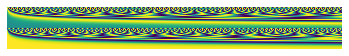

In [6]:
#sinusoidal init
singrating=np.array(models.sinusoidal_init()(key, (10,256)))
plt.axis('off')
plt.imshow(singrating[0].T)

# posemb

In [7]:
posemb = models.AddPositionEmbs(name='foo')
out, params = posemb.init(key, random.uniform(key, (16, 32, 64)))
out.shape, tree_shape(params)

((16, 32, 64), {})

# mlp

In [8]:
mlp = models.MlpBlock(mlp_dim=256, name='mlp', deterministic=True)
out, params = mlp.init(key, random.uniform(key, (16, 32, 64)))
out.shape, tree_shape(params)

((16, 32, 64),
 {'Dense_0': {'bias': (256,), 'kernel': (64, 256)},
  'Dense_1': {'bias': (64,), 'kernel': (256, 64)}})

In [9]:
mlp = models.MlpBlock(mlp_dim=256, name='mlp', deterministic=False)
with nn.stochastic(key):
  out, params = mlp.init(key, random.uniform(key, (16, 32, 64)))
out.shape, tree_shape(params)

((16, 32, 64),
 {'Dense_0': {'bias': (256,), 'kernel': (64, 256)},
  'Dense_1': {'bias': (64,), 'kernel': (256, 64)}})

In [10]:
mlpP = partial(models.MlpBlock, mlp_dim=256, name='mlp')
mlp = mlpP(deterministic=False)
with nn.stochastic(key):
  out, params = mlp.init(key, random.uniform(key, (16, 32, 64)))
out.shape, tree_shape(params)

((16, 32, 64),
 {'Dense_0': {'bias': (256,), 'kernel': (64, 256)},
  'Dense_1': {'bias': (64,), 'kernel': (256, 64)}})

# encoder1dblock

In [11]:
encblk = models.Encoder1DBlock(qkv_dim=64, mlp_dim=256, num_heads=2, name='encblk')
with nn.stochastic(key):
  out, params = encblk.init(key, random.uniform(key, (16, 32, 64)))
out.shape, tree_shape(params)

((16, 32, 64),
 {'LayerNorm_0': {'bias': (64,), 'scale': (64,)},
  'LayerNorm_2': {'bias': (64,), 'scale': (64,)},
  'MlpBlock_3': {'Dense_0': {'bias': (256,), 'kernel': (64, 256)},
   'Dense_1': {'bias': (64,), 'kernel': (256, 64)}},
  'MultiHeadDotProductAttention_1': {'key': {'kernel': (64, 2, 32)},
   'out': {'kernel': (2, 32, 64)},
   'query': {'kernel': (64, 2, 32)},
   'value': {'kernel': (64, 2, 32)}}})

# encoderdecoder1dblk

In [12]:
endecblk = models.EncoderDecoder1DBlock(qkv_dim=64, mlp_dim=256, num_heads=2, name='endecblk')
with nn.stochastic(key):
  out, params = endecblk.init(key, random.uniform(key, (16, 32, 64)), random.uniform(key, (16, 32, 64)))
out.shape, tree_shape(params)

((16, 32, 64),
 {'LayerNorm_0': {'bias': (64,), 'scale': (64,)},
  'LayerNorm_2': {'bias': (64,), 'scale': (64,)},
  'LayerNorm_4': {'bias': (64,), 'scale': (64,)},
  'MlpBlock_5': {'Dense_0': {'bias': (256,), 'kernel': (64, 256)},
   'Dense_1': {'bias': (64,), 'kernel': (256, 64)}},
  'MultiHeadDotProductAttention_1': {'key': {'kernel': (64, 2, 32)},
   'out': {'kernel': (2, 32, 64)},
   'query': {'kernel': (64, 2, 32)},
   'value': {'kernel': (64, 2, 32)}},
  'MultiHeadDotProductAttention_3': {'key': {'kernel': (64, 2, 32)},
   'out': {'kernel': (2, 32, 64)},
   'query': {'kernel': (64, 2, 32)},
   'value': {'kernel': (64, 2, 32)}}})

# encoder

In [13]:
encoder = models.Encoder(vocab_size=100, emb_dim=64, num_heads=2, num_layers=2, qkv_dim=64, mlp_dim=256, name='encoder')
with nn.stochastic(key):
  out, params = encoder.init(key, random.uniform(key, (16, 32)))
out.shape, tree_shape(params)

((16, 32, 64),
 {'Embed_0': {'embedding': (100, 64)},
  'encoder_norm': {'bias': (64,), 'scale': (64,)},
  'encoderblock_0': {'LayerNorm_0': {'bias': (64,), 'scale': (64,)},
   'LayerNorm_2': {'bias': (64,), 'scale': (64,)},
   'MlpBlock_3': {'Dense_0': {'bias': (256,), 'kernel': (64, 256)},
    'Dense_1': {'bias': (64,), 'kernel': (256, 64)}},
   'MultiHeadDotProductAttention_1': {'key': {'kernel': (64, 2, 32)},
    'out': {'kernel': (2, 32, 64)},
    'query': {'kernel': (64, 2, 32)},
    'value': {'kernel': (64, 2, 32)}}},
  'encoderblock_1': {'LayerNorm_0': {'bias': (64,), 'scale': (64,)},
   'LayerNorm_2': {'bias': (64,), 'scale': (64,)},
   'MlpBlock_3': {'Dense_0': {'bias': (256,), 'kernel': (64, 256)},
    'Dense_1': {'bias': (64,), 'kernel': (256, 64)}},
   'MultiHeadDotProductAttention_1': {'key': {'kernel': (64, 2, 32)},
    'out': {'kernel': (2, 32, 64)},
    'query': {'kernel': (64, 2, 32)},
    'value': {'kernel': (64, 2, 32)}}},
  'posembed_input': {}})

# decoder

In [14]:
decoder = models.Decoder(output_vocab_size=100, emb_dim=64, num_heads=2, num_layers=2, qkv_dim=64, mlp_dim=256, name='decoder')
inputs=random.uniform(key, (16, 32))
src_padding_mask = (inputs > 0)[..., None]
encoded=random.uniform(key, (16, 32, 64))
targets=random.uniform(key, (16, 32))
with nn.stochastic(key):
  out, params = decoder.init(key, encoded, src_padding_mask, targets)
out.shape, tree_shape(params)

((16, 32, 100),
 {'Embed_0': {'embedding': (100, 64)},
  'encoderdecoder_norm': {'bias': (64,), 'scale': (64,)},
  'encoderdecoderblock_0': {'LayerNorm_0': {'bias': (64,), 'scale': (64,)},
   'LayerNorm_2': {'bias': (64,), 'scale': (64,)},
   'LayerNorm_4': {'bias': (64,), 'scale': (64,)},
   'MlpBlock_5': {'Dense_0': {'bias': (256,), 'kernel': (64, 256)},
    'Dense_1': {'bias': (64,), 'kernel': (256, 64)}},
   'MultiHeadDotProductAttention_1': {'key': {'kernel': (64, 2, 32)},
    'out': {'kernel': (2, 32, 64)},
    'query': {'kernel': (64, 2, 32)},
    'value': {'kernel': (64, 2, 32)}},
   'MultiHeadDotProductAttention_3': {'key': {'kernel': (64, 2, 32)},
    'out': {'kernel': (2, 32, 64)},
    'query': {'kernel': (64, 2, 32)},
    'value': {'kernel': (64, 2, 32)}}},
  'encoderdecoderblock_1': {'LayerNorm_0': {'bias': (64,), 'scale': (64,)},
   'LayerNorm_2': {'bias': (64,), 'scale': (64,)},
   'LayerNorm_4': {'bias': (64,), 'scale': (64,)},
   'MlpBlock_5': {'Dense_0': {'bias': (256

# transformer

In [22]:
transformer = models.Transformer(vocab_size=100, output_vocab_size=100, emb_dim=64, num_heads=2, num_layers=2, qkv_dim=64, mlp_dim=256, train=True, name='transformer')
inputs=random.uniform(key, (16, 32))
src_padding_mask = (inputs > 0)[..., None]
encoded=random.uniform(key, (16, 32, 64))
targets=random.uniform(key, (16, 32))
with nn.stochastic(key):
  out, params = transformer.init(key, inputs, targets)
print(out.shape)
with nn.stochastic(key):
  out = transformer.call(params, inputs, targets)
out.shape, tree_shape(params)

(16, 32, 100)


((16, 32, 100),
 {'decoder': {'Embed_0': {'embedding': (100, 64)},
   'encoderdecoder_norm': {'bias': (64,), 'scale': (64,)},
   'encoderdecoderblock_0': {'LayerNorm_0': {'bias': (64,), 'scale': (64,)},
    'LayerNorm_2': {'bias': (64,), 'scale': (64,)},
    'LayerNorm_4': {'bias': (64,), 'scale': (64,)},
    'MlpBlock_5': {'Dense_0': {'bias': (256,), 'kernel': (64, 256)},
     'Dense_1': {'bias': (64,), 'kernel': (256, 64)}},
    'MultiHeadDotProductAttention_1': {'key': {'kernel': (64, 2, 32)},
     'out': {'kernel': (2, 32, 64)},
     'query': {'kernel': (64, 2, 32)},
     'value': {'kernel': (64, 2, 32)}},
    'MultiHeadDotProductAttention_3': {'key': {'kernel': (64, 2, 32)},
     'out': {'kernel': (2, 32, 64)},
     'query': {'kernel': (64, 2, 32)},
     'value': {'kernel': (64, 2, 32)}}},
   'encoderdecoderblock_1': {'LayerNorm_0': {'bias': (64,), 'scale': (64,)},
    'LayerNorm_2': {'bias': (64,), 'scale': (64,)},
    'LayerNorm_4': {'bias': (64,), 'scale': (64,)},
    'MlpBlock

In [23]:
with nn.stochastic(key):
  out = nn.call(transformer.encode, params, inputs)
out.shape

(16, 32, 64)

In [26]:
with nn.stochastic(key):
  out = nn.call(transformer.decode, params, encoded, src_padding_mask, targets)
out.shape

(16, 32, 100)

In [31]:
def foo(a, b, c=3):
  return a, b+c
pfoo = partial(foo, 4, c=4)
pfoo(4)

(4, 8)

In [46]:
encoder.

In [51]:
d1 = {'a':1}
{**d1, **{'b':3}}

{'a': 1, 'b': 3}

In [52]:
def foo(*args, **kwargs):
  print(kwargs)
foo(**d1, **{'b':2})

{'a': 1, 'b': 2}
